# Baseline Model

In [387]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Preprocessing

In [388]:
df = pd.read_csv("final_enriched_dataset.csv")
london_df = df[df["city"].str.lower() == "london"].copy()
london_df.head(5)

/var/folders/fc/6yc1nz0x6x7fmdkjy4089fdh0000gn/T/ipykernel_15219/2731615418.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_enriched_dataset.csv")


,Unnamed: 0,sale_price,bedrooms,bathrooms,living_area,postcode,city,country,dataset_date,currency,...,num_dining_drinking,num_retail_shopping,num_education,num_recreation,num_entertainment,num_transportation,num_healthcare,num_professional,num_high_rating_venues,median_income
74072,74724,1675000.0,5.0,5.0,2716.0,SW198NY,London,UK,2018-09-02,GBP,...,25,13,2,0,3,0,1,1,12,105000.0
74073,74725,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,...,36,2,1,0,6,1,0,0,39,70875.0
74074,74725,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,...,36,2,1,0,6,1,0,0,39,70875.0
74075,74725,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,...,36,2,1,0,6,1,0,0,39,70875.0
74076,74725,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,...,36,2,1,0,6,1,0,0,39,70875.0


In [389]:
y = london_df["sale_price_usd_inflation_adjusted"]
X = london_df.drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# Do split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.17647, random_state=42
)

print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

Train/Val/Test sizes: 4000/858/858


In [390]:
# Data preprocessing
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("oh",     OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline,     num_cols),
    ("cat", categorical_pipeline, cat_cols),
], remainder="drop")

## Linear Regression

In [391]:
model = Pipeline([
    ("prep", preprocess),
    ("reg",  LinearRegression()),
])

model.fit(X_train, y_train)

print('***** Results of linear regression model on London dataset *****')

predictions_train = model.predict(X_train)
score_mse_train = mean_squared_error(y_train, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_train, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = model.predict(X_test)
score_mse_test = mean_squared_error(y_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = predictions_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of linear regression model on London dataset *****
Training set RMSE: 1155015.5847
Training set r-squared scores: 0.9028
Testing set RMSE: 1862277.9095
Testing set r-squared scores: 0.6145
Mean Price: 3042066.168068731


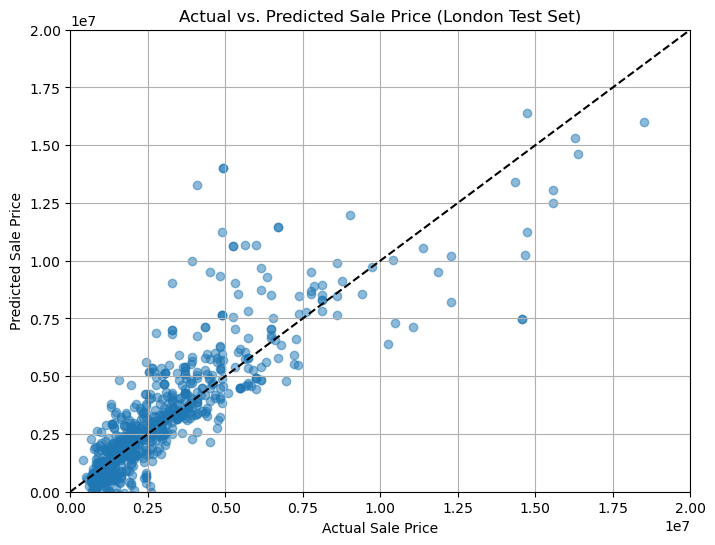

In [392]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, alpha=0.5)
lims = [min(y_test.min(), predictions_test.min()), max(y_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price (London Test Set)")
plt.grid(True)
plt.show()

## Ridge Regression

### Tuning on Validation Set

In [393]:
alphas = [(0.01 * i) for i in range(100)]
best_alpha = None
best_rmse  = float("inf")

for alpha in alphas:
    model = Pipeline([
        ("prep", preprocess),
        ("reg",  Ridge(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    rmse_val  = np.sqrt(mean_squared_error(y_val, preds_val))
    print(f"alpha={alpha:<5} → Val RMSE: {rmse_val:,.2f}")
    if rmse_val < best_rmse:
        best_rmse  = rmse_val
        best_alpha = alpha

print(f"\nBest alpha on validation: {best_alpha} (RMSE={best_rmse:,.2f})")

alpha=0.0   → Val RMSE: 1,813,785.55
alpha=0.01  → Val RMSE: 1,811,317.58
alpha=0.02  → Val RMSE: 1,809,820.19
alpha=0.03  → Val RMSE: 1,808,708.77
alpha=0.04  → Val RMSE: 1,807,865.52
alpha=0.05  → Val RMSE: 1,806,685.50
alpha=0.06  → Val RMSE: 1,806,958.81
alpha=0.07  → Val RMSE: 1,806,838.77
alpha=0.08  → Val RMSE: 1,806,984.86
alpha=0.09  → Val RMSE: 1,806,824.67
alpha=0.1   → Val RMSE: 1,807,245.88
alpha=0.11  → Val RMSE: 1,807,802.79
alpha=0.12  → Val RMSE: 1,808,443.66
alpha=0.13  → Val RMSE: 1,809,182.51
alpha=0.14  → Val RMSE: 1,810,015.51
alpha=0.15  → Val RMSE: 1,810,897.57
alpha=0.16  → Val RMSE: 1,811,865.63
alpha=0.17  → Val RMSE: 1,812,889.24
alpha=0.18  → Val RMSE: 1,813,385.77
alpha=0.19  → Val RMSE: 1,814,539.76
alpha=0.2   → Val RMSE: 1,815,659.86
alpha=0.21  → Val RMSE: 1,817,433.08
alpha=0.22  → Val RMSE: 1,818,659.48
alpha=0.23  → Val RMSE: 1,819,404.98
alpha=0.24  → Val RMSE: 1,820,748.45
alpha=0.25  → Val RMSE: 1,822,103.46
alpha=0.26  → Val RMSE: 1,823,435.25
a

In [394]:
model = Pipeline([
    ("prep", preprocess),
    ("reg",  Ridge(alpha=best_alpha))
])

# Combine train and val for training set
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

model.fit(X_train, y_train)

print('***** Results of ridge regression model on London dataset *****')

predictions_train = model.predict(X_trainval)
score_mse_train = mean_squared_error(y_trainval, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_trainval, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = model.predict(X_test)
score_mse_test = mean_squared_error(y_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = predictions_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of ridge regression model on London dataset *****
Training set RMSE: 1296753.7514
Training set r-squared scores: 0.8853
Testing set RMSE: 1810088.4250
Testing set r-squared scores: 0.6358
Mean Price: 3036634.5997789716


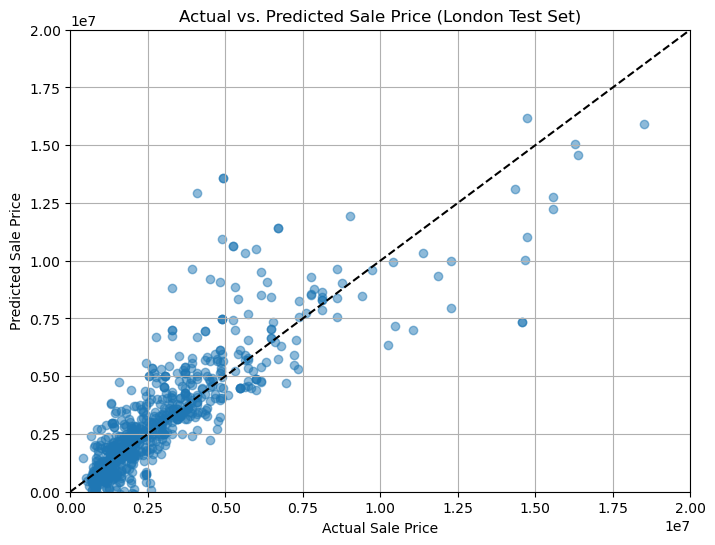

In [395]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, alpha=0.5)
lims = [min(y_test.min(), predictions_test.min()), max(y_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price (London Test Set)")
plt.grid(True)
plt.show()

# Teacher-student Model

## Preprocessing

In [396]:
parents = df[df["city"].isin(
    ["King County", "Melbourne", "New York", "Perth"]
)].copy()
london  = df[df["city"].str.lower() == "london"].copy()

X_par, y_par = parents.drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"]), parents["sale_price_usd_inflation_adjusted"]
X_lon, y_lon = london .drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"]), london["sale_price_usd_inflation_adjusted"]

# num_cols = X_par.select_dtypes(include=["int64","float64"]).columns
# cat_cols = X_par.select_dtypes(include=["object","category"]).columns

# num_cols = X_lon.select_dtypes(include=["int64","float64"]).columns
# cat_cols = X_lon.select_dtypes(include=["object","category"]).columns

# cat_cols = X_par.select_dtypes(include=["object","category"]).columns
# X_par[cat_cols] = X_par[cat_cols].astype(str)
# X_lon[cat_cols] = X_lon[cat_cols].astype(str)

cat_cols = X_par.select_dtypes(include=["object","category"]).columns
X_par[cat_cols] = X_par[cat_cols].astype(str)
X_lon[cat_cols] = X_lon[cat_cols].astype(str)

num_cols = X_par.select_dtypes(include=["int64","float64"]).columns

In [397]:
# Do parent split (80/20) for training/validation
X_P_train, X_P_val, y_P_train, y_P_val = train_test_split(
    X_par, y_par, test_size=0.20, random_state=42
)

# Do student split (70/15/15) for training/validation/test
X_L_temp, X_L_test, y_L_temp, y_L_test = train_test_split(
    X_lon, y_lon, test_size=0.15, random_state=42
)

X_L_train, X_L_val, y_L_train, y_L_val = train_test_split(
    X_L_temp, y_L_temp, test_size=0.17647, random_state=42
)

print(f"Parent Train/Val sizes: {len(X_P_train)}/{len(X_P_val)}")
print(f"London Train/Val/Test sizes: {len(X_L_train)}/{len(X_L_val)}/{len(X_L_test)}")

num_cols = X_par.select_dtypes(include=["int64","float64"]).columns

Parent Train/Val sizes: 59257/14815
London Train/Val/Test sizes: 4000/858/858


In [398]:
preprocess_parent = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

preprocess_london = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

### Tuning the Validation Set for Parent

In [399]:
alphas = [(20 * i) for i in range(50)]
best_alpha = None
best_rmse  = float("inf")

for alpha in alphas:
    model = Pipeline([
        ("prep", preprocess_parent),
        ("reg",  Ridge(alpha=alpha))
    ])
    model.fit(X_P_train, y_P_train)
    preds_val = model.predict(X_P_val)
    rmse_val  = np.sqrt(mean_squared_error(y_P_val, preds_val))
    print(f"alpha={alpha:<5} → Val RMSE: {rmse_val:,.2f}")
    if rmse_val < best_rmse:
        best_rmse  = rmse_val
        best_alpha = alpha

print(f"\nBest alpha on validation: {best_alpha} (RMSE={best_rmse:,.2f})")

teacher = Pipeline([
    ("prep", preprocess_parent),
    ("reg",  Ridge(alpha=10.0))
])
teacher.fit(X_par, y_par)

alpha=0     → Val RMSE: 2,201,928.87
alpha=20    → Val RMSE: 1,535,933.79
alpha=40    → Val RMSE: 1,299,279.04
alpha=60    → Val RMSE: 1,189,765.94
alpha=80    → Val RMSE: 1,131,264.42
alpha=100   → Val RMSE: 1,096,934.59
alpha=120   → Val RMSE: 1,075,390.49
alpha=140   → Val RMSE: 1,061,130.72
alpha=160   → Val RMSE: 1,051,324.44
alpha=180   → Val RMSE: 1,044,354.39
alpha=200   → Val RMSE: 1,039,289.44
alpha=220   → Val RMSE: 1,035,523.83
alpha=240   → Val RMSE: 1,032,645.76
alpha=260   → Val RMSE: 1,030,467.00
alpha=280   → Val RMSE: 1,028,775.69
alpha=300   → Val RMSE: 1,027,448.95
alpha=320   → Val RMSE: 1,026,399.61
alpha=340   → Val RMSE: 1,025,564.23
alpha=360   → Val RMSE: 1,024,869.02
alpha=380   → Val RMSE: 1,024,335.37
alpha=400   → Val RMSE: 1,023,904.84
alpha=420   → Val RMSE: 1,023,556.77
alpha=440   → Val RMSE: 1,023,274.79
alpha=460   → Val RMSE: 1,023,046.54
alpha=480   → Val RMSE: 1,022,861.89
alpha=500   → Val RMSE: 1,022,712.90
alpha=520   → Val RMSE: 1,022,592.93
a

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'bedrooms', 'bathrooms', 'living_area', 'latitude',
       'longitude', 'total_venues', 'avg_venue_rating', 'avg_venue_popularity',
       'num_dining_drinking', 'num_retail_shopping', 'num_education',
       'num_...portation',
       'num_healthcare', 'num_professional', 'num_high_rating_venues',
       'median_income'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['postcode', 'city', 'country', 'dataset_date', 'currency'], dtype='object'))])),
                ('reg', Ridge(alpha=10.0))])

### Tuning the Validation Set for Student

In [400]:
alphas = [(0.05 * i) for i in range(50)]
best_alpha = None
best_rmse  = float("inf")

for alpha in alphas:
    # teacher predictions on London train
    z_T = teacher.predict(X_L_train)

    # Joint loss pseudo labels
    y_pseudo = alpha * y_L_train.values + (1 - alpha) * z_T

    # Ridge on London with pseudo labels
    model = Pipeline([
        ("prep", preprocess_london),
        ("reg",  Ridge(alpha=alpha))
    ])
    model.fit(X_L_train, y_pseudo)

    preds_val = model.predict(X_L_val)
    rmse_val  = np.sqrt(mean_squared_error(y_L_val, preds_val))
    print(f"alpha={alpha:<5} → Val RMSE: {rmse_val:,.2f}")
    if rmse_val < best_rmse:
        best_rmse  = rmse_val
        best_alpha = alpha

print(f"\nBest alpha on validation: {best_alpha} (RMSE={best_rmse:,.2f})")

alpha=0.0   → Val RMSE: 4,110,381.20
alpha=0.05  → Val RMSE: 3,960,114.69
alpha=0.1   → Val RMSE: 3,805,280.64
alpha=0.15000000000000002 → Val RMSE: 3,661,139.32
alpha=0.2   → Val RMSE: 3,521,307.39
alpha=0.25  → Val RMSE: 3,385,478.63
alpha=0.30000000000000004 → Val RMSE: 3,253,529.40
alpha=0.35000000000000003 → Val RMSE: 3,125,421.95
alpha=0.4   → Val RMSE: 3,001,335.90
alpha=0.45  → Val RMSE: 2,881,040.69
alpha=0.5   → Val RMSE: 2,765,244.45
alpha=0.55  → Val RMSE: 2,654,072.64
alpha=0.6000000000000001 → Val RMSE: 2,547,093.12
alpha=0.65  → Val RMSE: 2,447,596.89
alpha=0.7000000000000001 → Val RMSE: 2,350,569.55
alpha=0.75  → Val RMSE: 2,261,045.16
alpha=0.8   → Val RMSE: 2,178,343.87
alpha=0.8500000000000001 → Val RMSE: 2,103,128.97
alpha=0.9   → Val RMSE: 2,036,588.95
alpha=0.9500000000000001 → Val RMSE: 1,979,118.18
alpha=1.0   → Val RMSE: 1,929,729.41
alpha=1.05  → Val RMSE: 1,890,096.42
alpha=1.1   → Val RMSE: 1,861,386.98
alpha=1.1500000000000001 → Val RMSE: 1,842,839.05
alpha

### Training Student with Best Hyperparameters

In [401]:
# teacher predictions on London train
z_T = teacher.predict(X_L_train)

# Joint loss pseudo labels
y_pseudo = alpha * y_L_train.values + (1 - alpha) * z_T

# Ridge on London with pseudo labels
model = Pipeline([
    ("prep", preprocess_london),
    ("reg",  Ridge(alpha=0.5))
])
model.fit(X_L_train, y_pseudo)

# Final evaluation
print('***** Results of teacher-student on London dataset *****')

predictions_train = model.predict(X_L_train)
score_mse_train = mean_squared_error(y_L_train, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_L_train, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = model.predict(X_L_test)
score_mse_test = mean_squared_error(y_L_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_L_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = y_L_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of teacher-student on London dataset *****
Training set RMSE: 4212920.1292
Training set r-squared scores: -0.2932
Testing set RMSE: 5062459.5352
Testing set r-squared scores: -1.8491
Mean Price: 2910567.5365336095


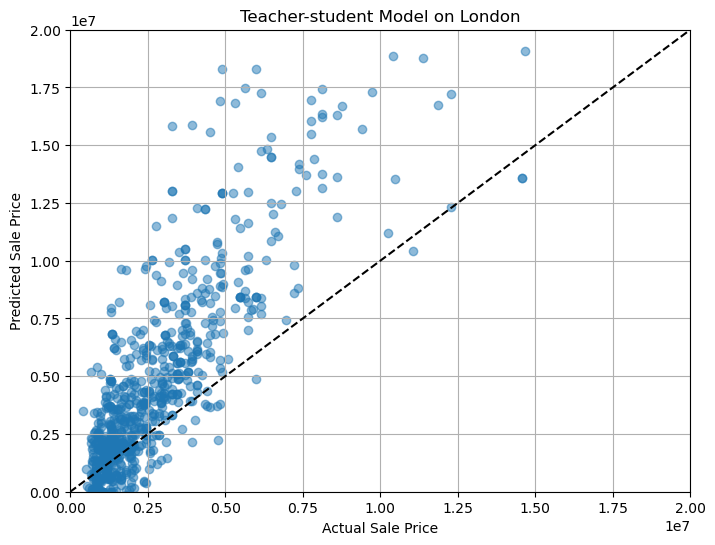

In [402]:
plt.figure(figsize=(8, 6))
plt.scatter(y_L_test, predictions_test, alpha=0.5)
lims = [min(y_L_test.min(), predictions_test.min()), max(y_L_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Teacher-student Model on London")
plt.grid(True)
plt.show()

In [403]:

# ── 4) Fix mixed‐type categoricals
cat_cols = X_par.select_dtypes(include=["object","category"]).columns
X_par[cat_cols] = X_par[cat_cols].astype(str)
X_lon[cat_cols] = X_lon[cat_cols].astype(str)

# ── 5) London train/test split
X_L_train, X_L_test, y_L_train, y_L_test = train_test_split(
    X_lon, y_lon, test_size=0.20, random_state=42
)

# ── 6) Build two separate preprocessors
num_cols = X_par.select_dtypes(include=["int64","float64"]).columns

preprocess_parent = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

preprocess_london = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

# ── 7) Teacher: Ridge on parent markets
teacher = Pipeline([
    ("prep", preprocess_parent),
    ("reg",  Ridge(alpha=10.0))
])
print("Training teacher on parent markets…")
teacher.fit(X_par, y_par)

# ── 8) Soft-labels: teacher predictions on London train
z_T = teacher.predict(X_L_train)

# ── 9) Pseudo-labels for joint loss
alpha = 0.5
y_pseudo = alpha * y_L_train.values + (1 - alpha) * z_T

# ── 10) Student: Ridge on London with pseudo-labels
student = Pipeline([
    ("prep", preprocess_london),
    ("reg",  Ridge(alpha=1.0))
])
print("Training student on London (joint‐loss pseudo-labels)…")
student.fit(X_L_train, y_pseudo)

# ── 11) Evaluate on London test
def report(name, model):
    preds = model.predict(X_L_test)
    rmse  = np.sqrt(mean_squared_error(y_L_test, preds))
    r2    = r2_score(y_L_test, preds)
    print(f"{name:<10} | RMSE: {rmse:,.0f}  R²: {r2:.3f}")

print("\n=== Distillation Results on London Test ===")
report("Teacher", teacher)
report("Student", student)

Training teacher on parent markets…
Training student on London (joint‐loss pseudo-labels)…

=== Distillation Results on London Test ===
Teacher    | RMSE: 2,640,017  R²: 0.182
Student    | RMSE: 1,635,292  R²: 0.686
